# StuctureCleaner

In order to most accurately parameterize the initial conditions of the phase field model, data is taken from the Austenite Reconstruction code developed by Dr. Miller's group. First, EBSD is used to scan the martensitic structure in the processed steel samples, yeilding both grain geometry and crystallographic orientation. Using known orientation relationships, the initial austenitic structure is predicted using the martensitic structure. This predicted austneite structure is then converted to MOOSE input syntax, which can be found at https://mooseframework.inl.gov/modules/phase_field/ICs/EBSD.html. 

Despite being reported in MOOSE input syntax, some additional steps must be taken before using this data as MOOSE initial conditions. This Jupyter Notebook will walk through each of those necessary steps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Raw data file location
data_loc = "./2.8.22 ML_AM_5_IH_M1_2 Run 1 Recont Aus.txt"

# Header length
head_N = 38

## Printing header

To make sure we understand the data we are working with, we print the header of the raw data file. 

In [2]:
with open(data_loc, "r") as file:
    for i in range(head_N):
        line = next(file).strip()
        print(line)

# Header:     Marmot Input File
#
# Column 1:  Euler angle "phi1" (in radians)
# Column 2:  Euler angle "PHI" (in radians)
# Column 3:  Euler angle "phi2" (in radians)
# Column 4:  x-coordinate (in microns)
# Column 5:  y-coordinate (in microns)
# Column 6:  z-coordinate (in microns)
# Column 7:  grain number (integer)
# Column 8:  phase number (integer)
# Column 9:  symmetry class (from TSL)
#
# Phase 1: notIndexed (symmetry class = 0)
# Number of grains in Phase 1: 0
#
# Phase 2: Iron bcc (old) (symmetry class = 45)
# Number of grains in Phase 2: 4
#
# Phase 3: Iron fcc (symmetry class = 45)
# Number of grains in Phase 3: 7
#
# X_Min:           0.0
# X_Max:         215.0
# X_step:          0.2
# X_Dim:           860
#
# Y_Min:           0.0
# Y_Max:         162.5
# Y_step:          0.2
# Y_Dim:           650
#
# Z_Min:      0.0
# Z_Max:      0.0
# Z_step:     0.0
# Z_Dim:      0
#
# Note:  This is a 2D dataset with z-coordinates set to zero!
#


## Convert data to pandas dataframe

First, we need to covert the data into a pandas dataframe, which will allow us to easily view and adit data as necessary. We make sure to skip over the header (38 lines), and just convert the data table.

In [8]:
df=pd.read_csv(data_loc, delim_whitespace=True, skiprows=head_N, 
               names=["phi1", "Phi", "phi2", "x", "y", "z", "grain", "phase", "symm"])

display(df)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.82355,1.62064,0.34219,0.0,81.8,0.0,1,2,45
1,2.84687,1.63417,0.36722,0.0,82.0,0.0,1,2,45
2,2.82989,1.61865,0.39340,0.0,82.2,0.0,1,2,45
3,2.84571,1.62231,0.36420,0.0,82.5,0.0,1,2,45
4,2.83276,1.61755,0.39437,0.0,82.8,0.0,1,2,45
...,...,...,...,...,...,...,...,...,...
559223,1.22383,1.79310,5.38629,215.0,161.2,0.0,11,3,45
559224,1.22737,1.79616,5.38593,215.0,161.5,0.0,11,3,45
559225,1.22317,1.80067,5.39178,215.0,161.8,0.0,11,3,45
559226,1.22844,1.79717,5.39678,215.0,162.0,0.0,11,3,45


# Observed errors

1. The values in the y direction have a physically unreasonable number of significant digits. I am assuming that there is a rounding error somewhere. This is confirmed by the value of `X_dim` in the header, which we would expect to be an integer number (we can't have a fractional number of elements). We can fix this by rounding the values of the y data points to one significant digit. 

2. We do not have the correct number of data points. From the header, we are expecting `X_dim+1` x `Y_dim+1` or 218,966 total data points. From the size of the pandas dataframe, we only have 218,050 data points. We need to diagnose why this is happening, and find a solution. 

3. The values of Euler angles within each grain vary significantly. While MOOSE does have the capability to average Euler angles within grains, it can result in errors in grain boundary demarcation.

4. MOOSE expects data points for each element to be located inside of each element. This raw data reports data points at element corners. We can fix this simply by applying a uniform translation of each data point to element centers. 

## Error 1: Error in y values

Using pandas, rounding the values of each y value to 1 decimal point is trivial

In [9]:
df.y=df.y.round(3)
display(df)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.82355,1.62064,0.34219,0.0,81.8,0.0,1,2,45
1,2.84687,1.63417,0.36722,0.0,82.0,0.0,1,2,45
2,2.82989,1.61865,0.39340,0.0,82.2,0.0,1,2,45
3,2.84571,1.62231,0.36420,0.0,82.5,0.0,1,2,45
4,2.83276,1.61755,0.39437,0.0,82.8,0.0,1,2,45
...,...,...,...,...,...,...,...,...,...
559223,1.22383,1.79310,5.38629,215.0,161.2,0.0,11,3,45
559224,1.22737,1.79616,5.38593,215.0,161.5,0.0,11,3,45
559225,1.22317,1.80067,5.39178,215.0,161.8,0.0,11,3,45
559226,1.22844,1.79717,5.39678,215.0,162.0,0.0,11,3,45


We need to save the correct dimensions of the data set for later use

In [10]:
X_Min = 0.0
X_Max = 215.0
X_step = 0.2
X_Dim = 860

Y_Min = 0.0
Y_Max = 162.5
Y_step = 0.2
Y_Dim = 650

## Error 2: Missing data points

To fix this issue, we first need to understand why we have fewer data points than expected. We can do this simply by plotting the location of each data point on a scatter plot.

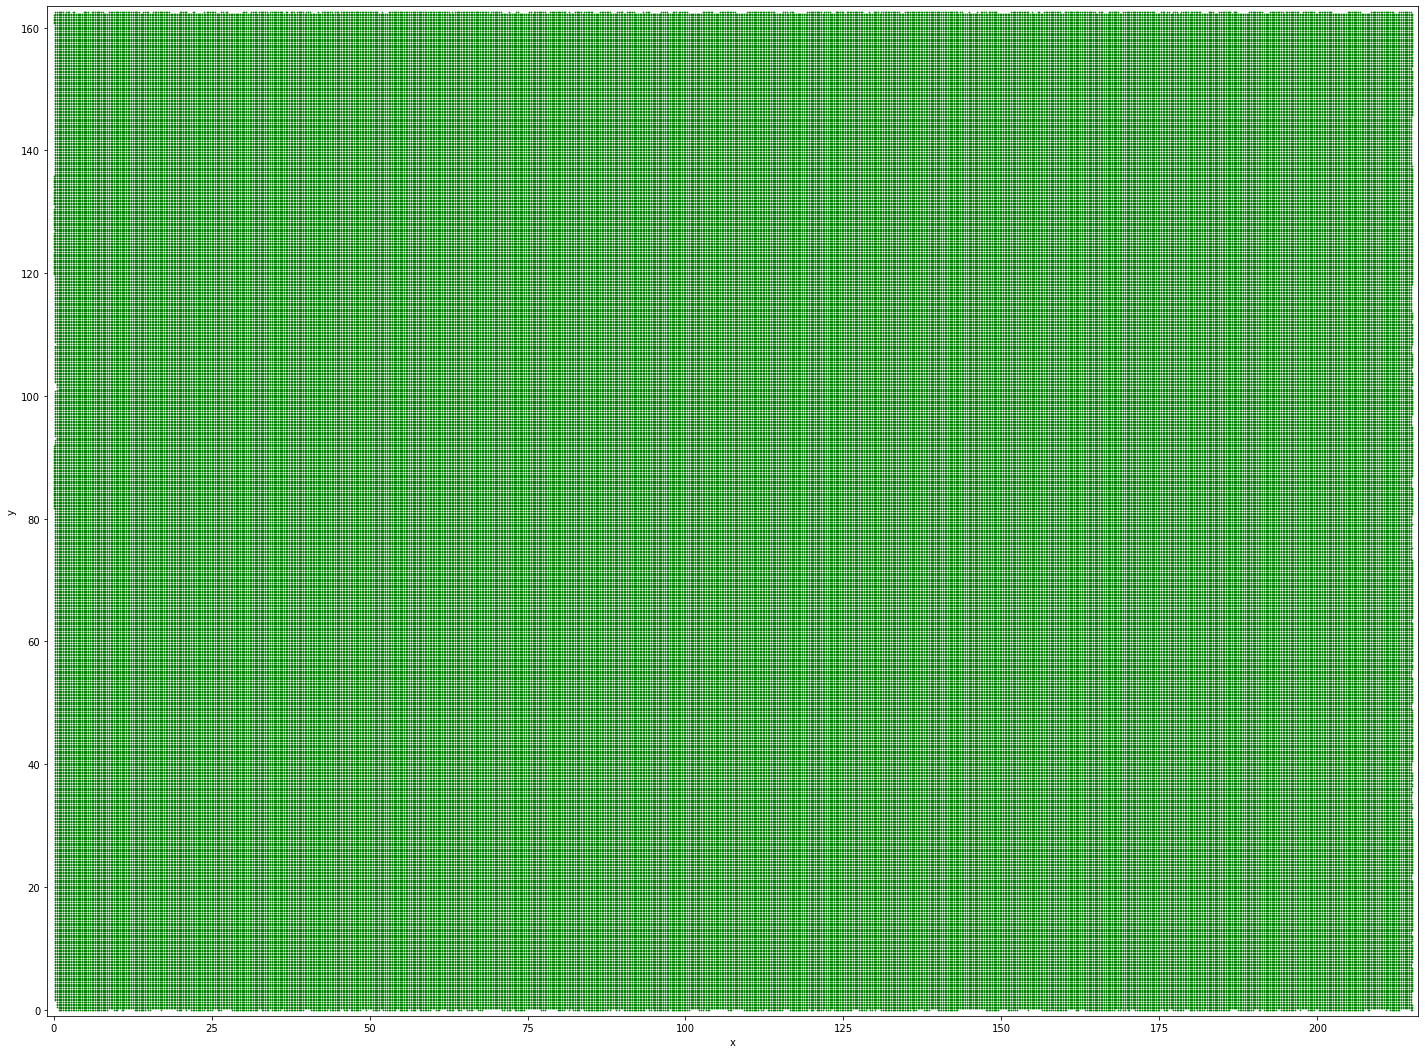

In [11]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df.x, df.y, s=0.5, c="g")

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-1,X_Max+1)
plt.ylim(-1,Y_Max+1)

plt.show()

The edges of this data set seem to be missing data point. We can zoom in on the lower right corner of the data set to confirm this.

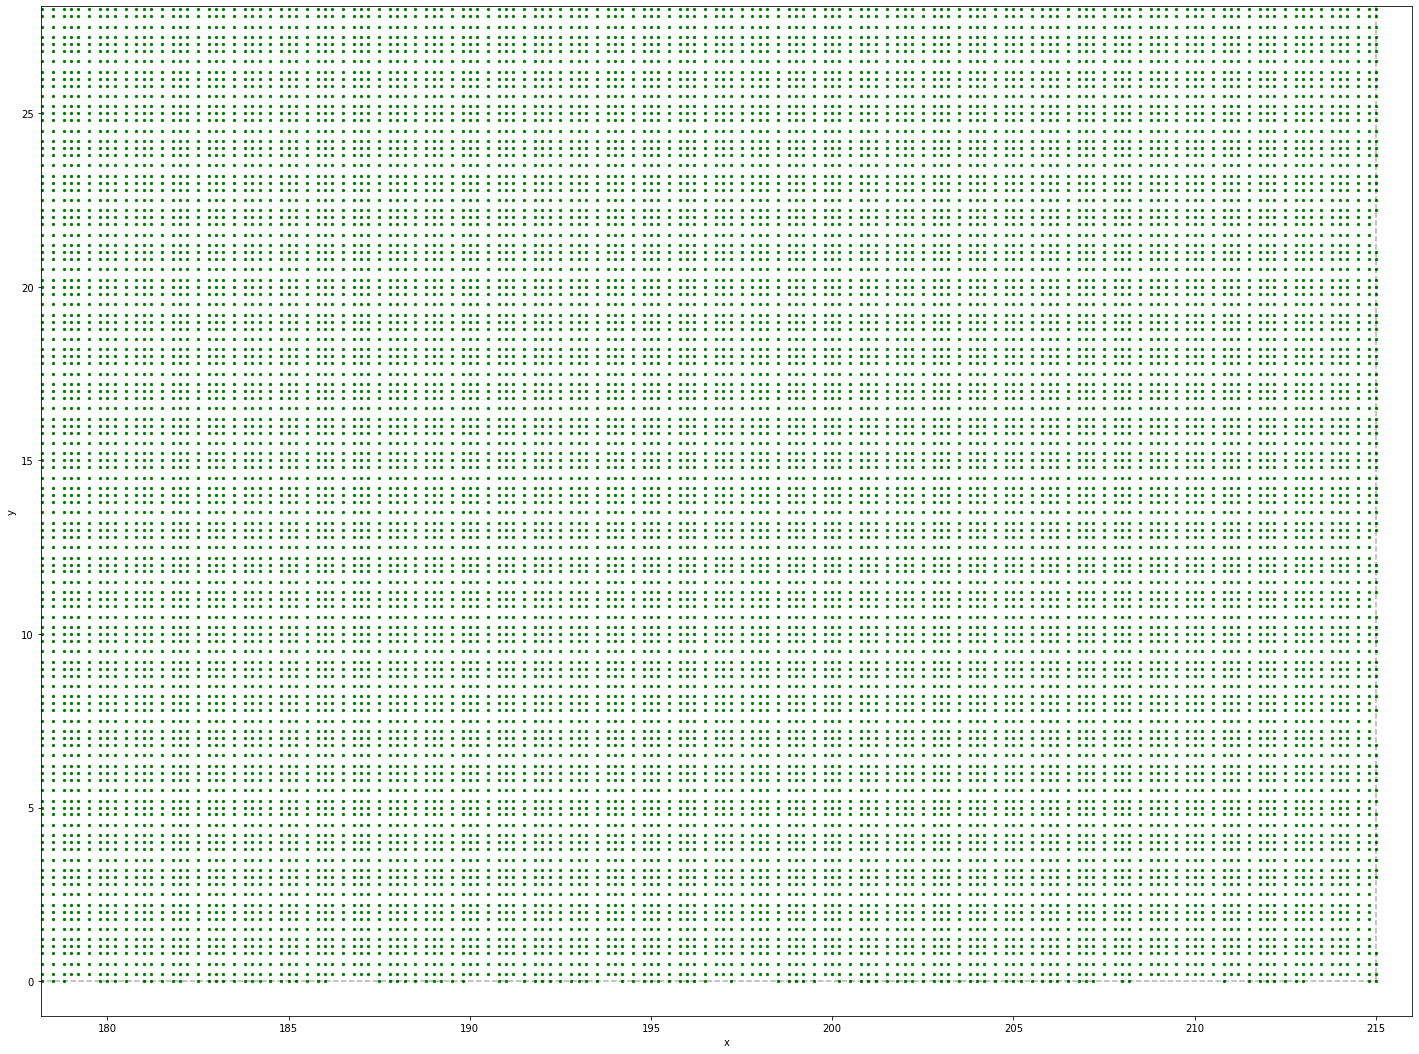

In [12]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df.x, df.y, s=5, c="g")

plt.plot([0, X_Max],[0, 0],'--', color='black', alpha=0.3)
plt.plot([X_Max, X_Max],[0, Y_Max],'--', color='black', alpha=0.3)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(((X_Max/6)*5)-1,X_Max+1)
plt.ylim(-1,((Y_Max/6))+1)

plt.show()

From the plot, we can clearly see that the SEM scan is missing data points around the edges. We can fix this by dropping the data around the edges. Visually, it seems dropping 5 data points around each edge of the image will be sufficient. 

In [13]:
dN = 5

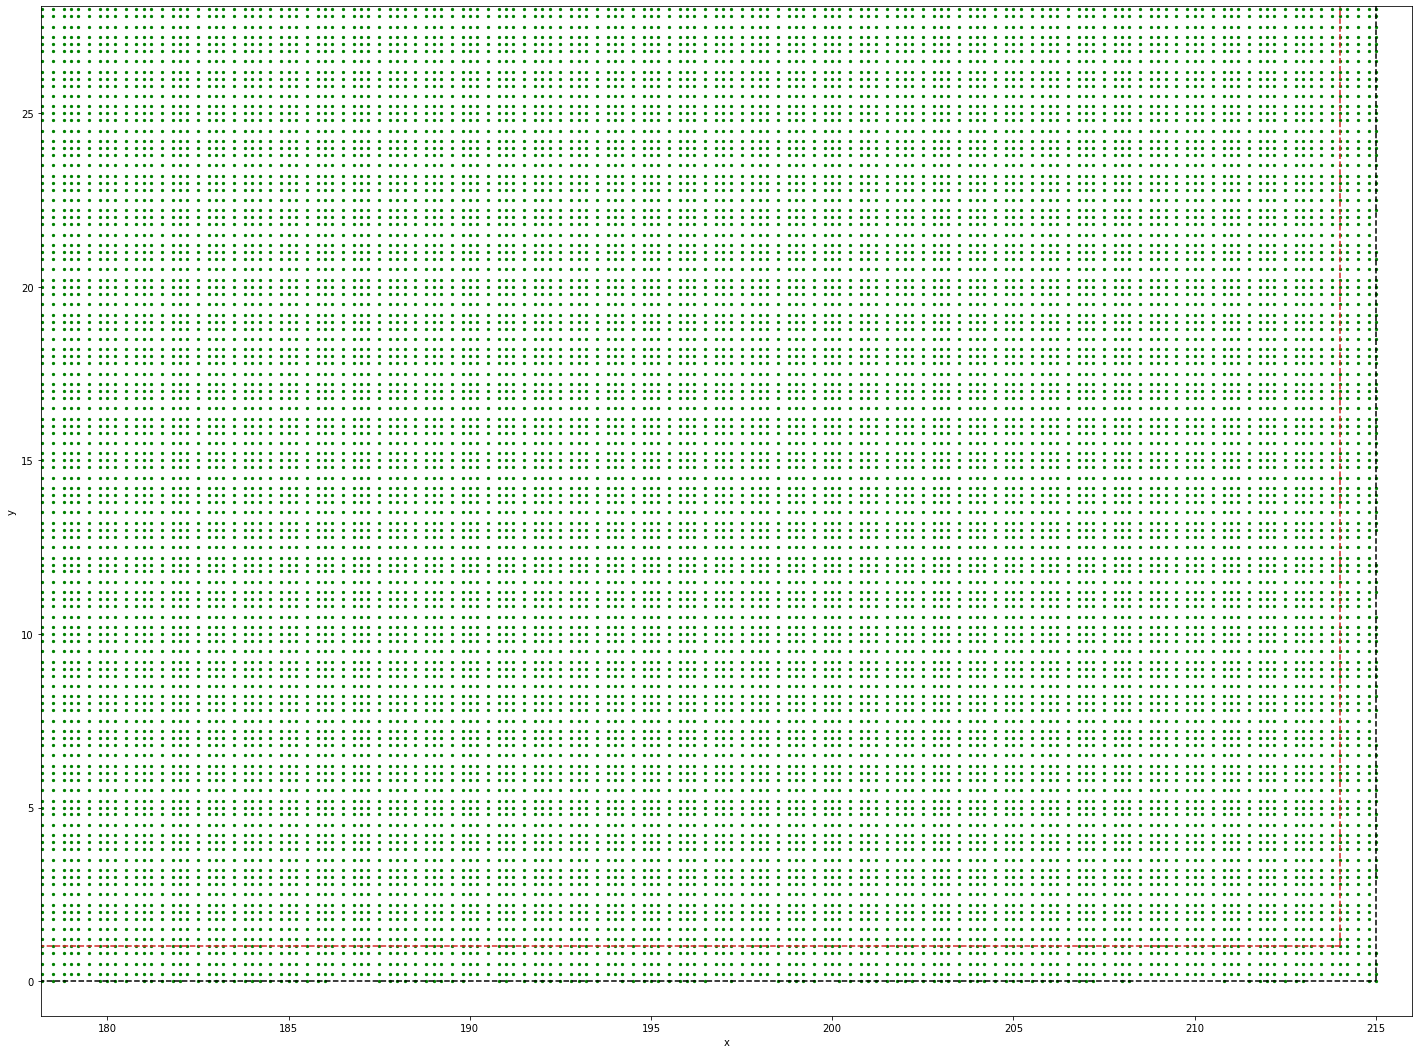

In [14]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df.x, df.y, s=5, c="g")

# Old Border
plt.plot([X_Min, X_Max],[Y_Max, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Min, X_Max],[Y_Min, Y_Min],'--', color='black', alpha=1)
plt.plot([X_Min, X_Min],[Y_Min, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Max, X_Max],[Y_Min, Y_Max],'--', color='black', alpha=1)

# New Border
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Max-(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Min+(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Min+(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Max-(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(((X_Max/6)*5)-1,X_Max+1)
plt.ylim(-1,((Y_Max/6))+1)

plt.show()

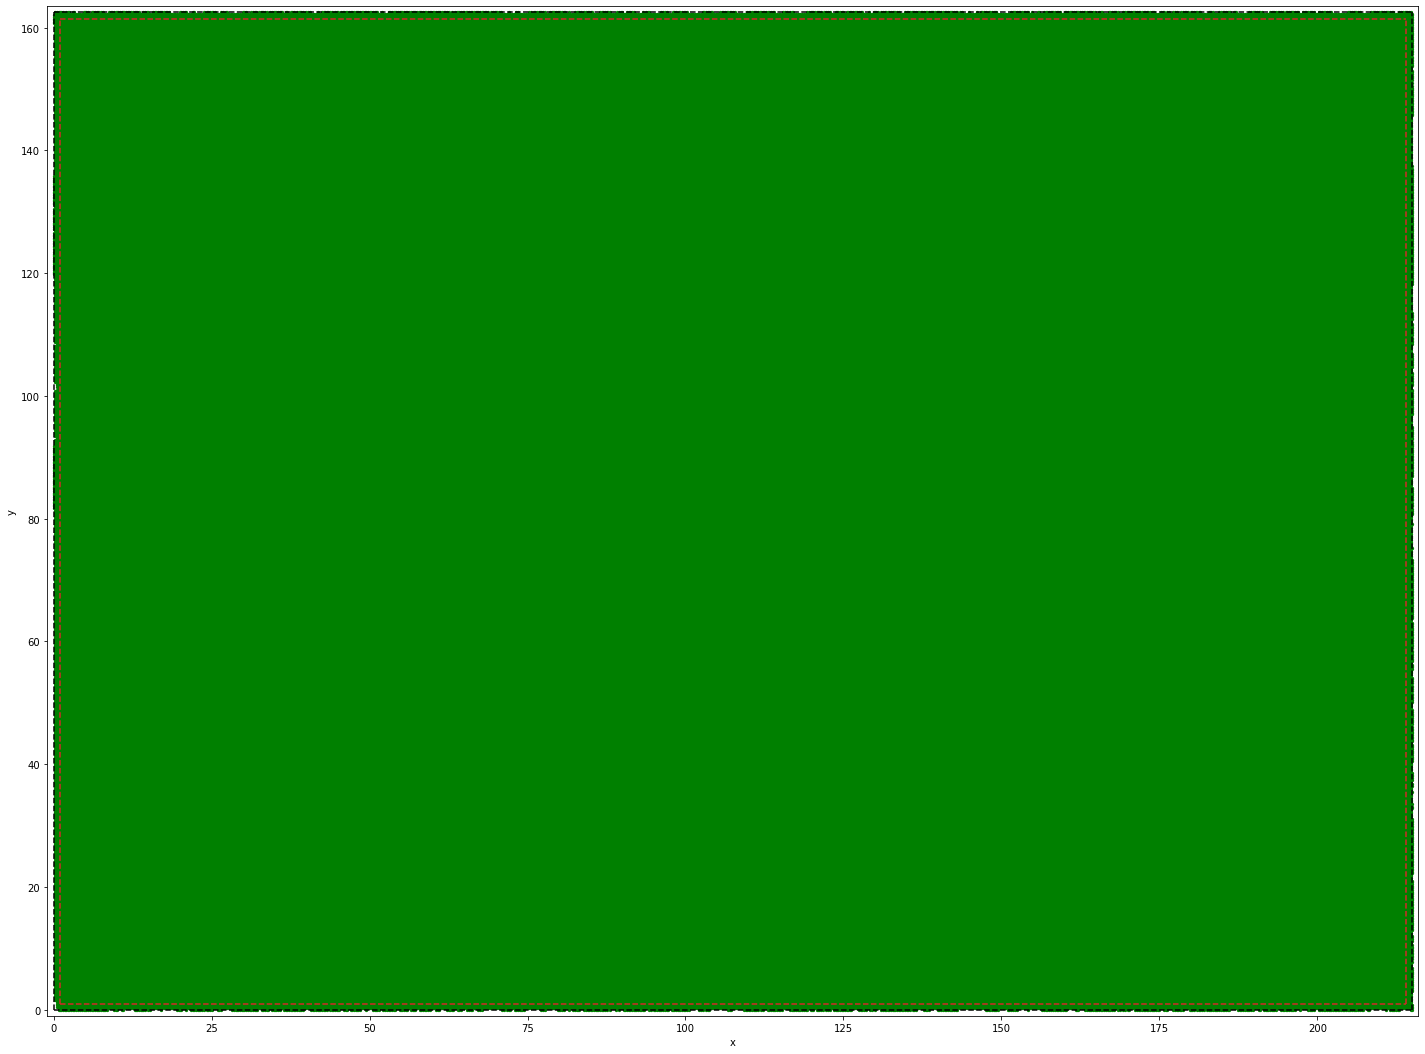

In [15]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df.x, df.y, s=5, c="g")

# Old Border
plt.plot([X_Min, X_Max],[Y_Max, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Min, X_Max],[Y_Min, Y_Min],'--', color='black', alpha=1)
plt.plot([X_Min, X_Min],[Y_Min, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Max, X_Max],[Y_Min, Y_Max],'--', color='black', alpha=1)

# New Border
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Max-(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Min+(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Min+(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Max-(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-1,X_Max+1)
plt.ylim(-1,Y_Max+1)

plt.show()

Now, we need to actually remove these data points from the pandas dataframe.

In [16]:
# Create new dataframe to maintain copy of full dataset
df_trim = df.copy()

# Drop rows for data points outside new trimmed window
df_trim.drop(df_trim[df_trim['y'] > Y_Max-(Y_step*dN)].index, inplace = True)
df_trim.drop(df_trim[df_trim['y'] < Y_Min+(Y_step*dN)].index, inplace = True)
df_trim.drop(df_trim[df_trim['x'] < X_Min+(X_step*dN)].index, inplace = True)
df_trim.drop(df_trim[df_trim['x'] > X_Max-(X_step*dN)].index, inplace = True)

# Reindex dataframe
df_trim = df_trim.reset_index()
df_trim.drop("index", inplace=True, axis=1)

display(df_trim)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.56361,0.38345,2.97821,1.0,1.0,0.0,9,3,45
1,2.56306,0.38266,2.97819,1.0,1.2,0.0,9,3,45
2,2.56305,0.38487,2.98028,1.0,1.5,0.0,9,3,45
3,2.53829,0.37421,3.00671,1.0,1.8,0.0,9,3,45
4,2.53013,0.38641,3.00909,1.0,2.0,0.0,9,3,45
...,...,...,...,...,...,...,...,...,...
548474,1.21107,1.81570,5.36010,214.0,160.5,0.0,11,3,45
548475,1.21222,1.80804,5.37240,214.0,160.8,0.0,11,3,45
548476,1.22112,1.81415,5.38312,214.0,161.0,0.0,11,3,45
548477,1.21973,1.81623,5.38011,214.0,161.2,0.0,11,3,45


Now we can plot the full data set to confirm the edges are smooth, and not missing any further data points

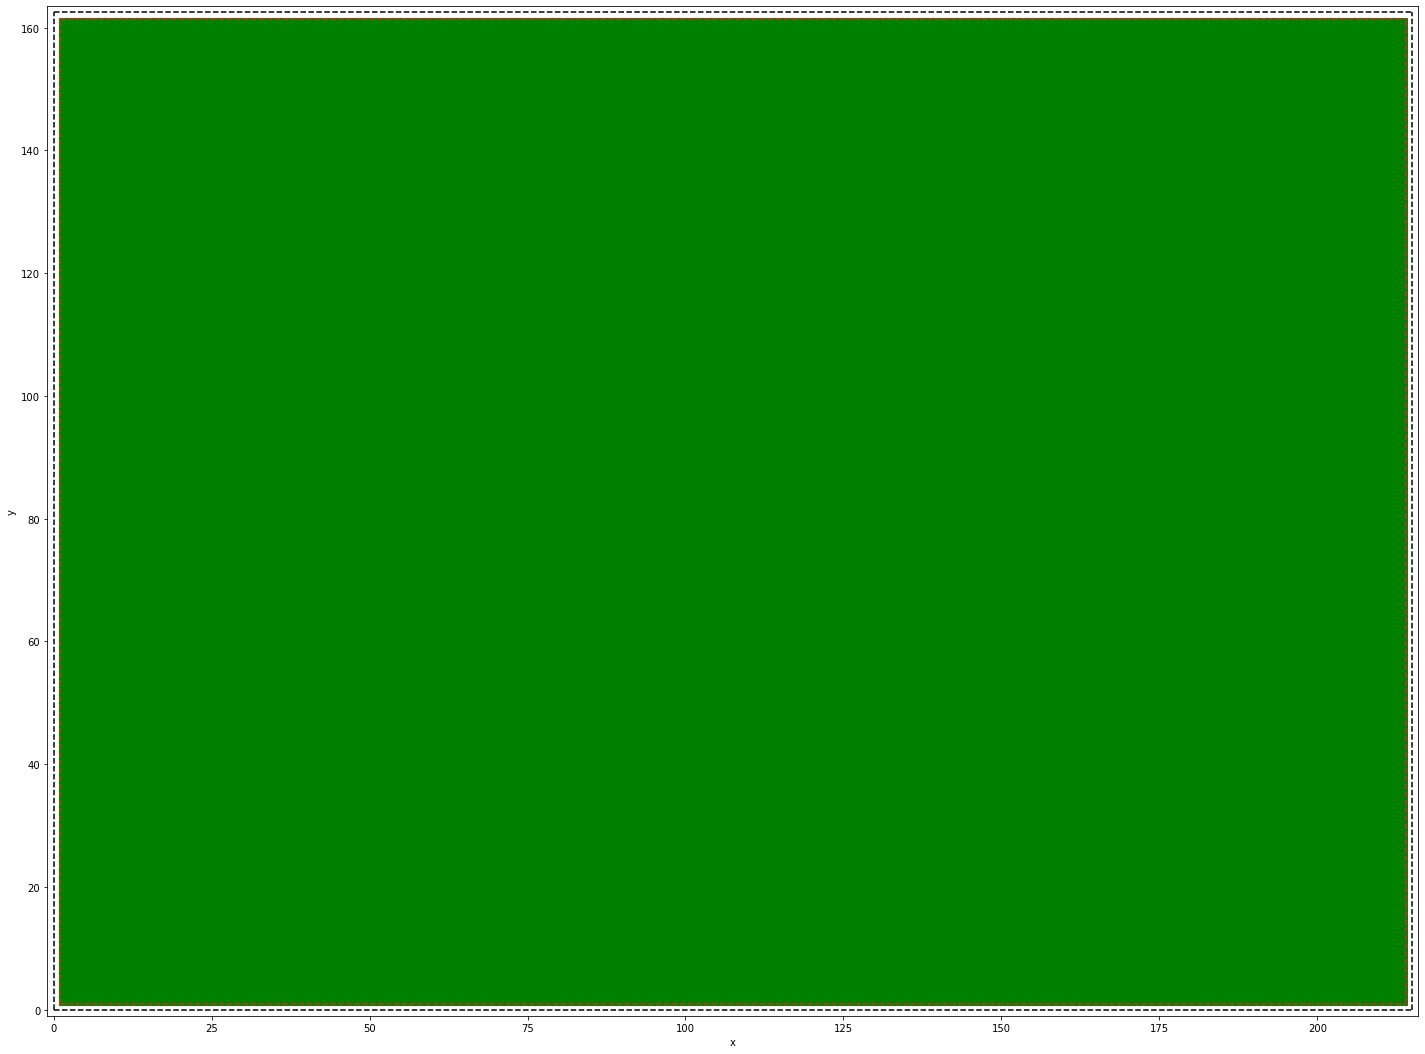

In [17]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df_trim.x, df_trim.y, s=5, c="g")

# Old Border
plt.plot([X_Min, X_Max],[Y_Max, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Min, X_Max],[Y_Min, Y_Min],'--', color='black', alpha=1)
plt.plot([X_Min, X_Min],[Y_Min, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Max, X_Max],[Y_Min, Y_Max],'--', color='black', alpha=1)

# New Border
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Max-(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Min+(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Min+(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Max-(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-1,X_Max+1)
plt.ylim(-1,Y_Max+1)

plt.show()

We also need to update the overall dimensions of the data set now that we have trimmed the edges. The step size had remained the same, however the min and max values of x and y have changed, as have the overall x and y dimention lengths. 

In [18]:
X_Max_trim = df_trim["x"].max()
X_Min_trim = df_trim["x"].min()
X_step_trim = X_step
X_Dim_trim = (X_Max_trim - X_Min_trim) / X_step

Y_Max_trim = df_trim["y"].max()
Y_Min_trim = df_trim["y"].min()
Y_step_trim = Y_step
Y_Dim_trim = (Y_Max_trim - Y_Min_trim) / Y_step


print("X_Max_trim:\t" + str(X_Max_trim))
print("X_Min_trim:\t" + str(X_Min_trim))
print("X_step_trim:\t" + str(X_step_trim))
print("X_Dim_trim:\t" + str(X_Dim_trim))
print("\n")
print("Y_Max_trim:\t" + str(Y_Max_trim))
print("Y_Min_trim:\t" + str(Y_Min_trim))
print("Y_step_trim:\t" + str(Y_step_trim))
print("Y_Dim_trim:\t" + str(Y_Dim_trim))
print("\n")
print("The dataframe has " + str(df_trim.shape[0]) + " data points")
print("We are expecting " + str(int((X_Dim_trim+1))) + " x " + str(int((Y_Dim_trim+1))) +
      " or " + str(int((X_Dim_trim+1)*(Y_Dim_trim+1))) + " data points")


if df_trim.shape[0] == (X_Dim_trim+1)*(Y_Dim_trim+1):
    print("We're gucci")
else:
    print("We're sad :\'(")


X_Max_trim:	214.0
X_Min_trim:	1.0
X_step_trim:	0.2
X_Dim_trim:	1065.0


Y_Max_trim:	161.5
Y_Min_trim:	1.0
Y_step_trim:	0.2
Y_Dim_trim:	802.5


The dataframe has 548479 data points
We are expecting 1066 x 803 or 856531 data points
We're sad :'(


## Error 3: Noise in Euler angle data

There is signifiacnt noise in the euler angle data reported by the EBSD scans. To remedy this, we will average the euler angle within each grain, such that any data point within a single grain will have the exact same euler angle. 

Here, we create a new dataframe, which contains the average phi1, Phi, and phi2 Euler angles for each grain. Note that the grain number is located in the "Grain" column, and does not correspond to the index on the left.

In [19]:
EAavg = df_trim.groupby("grain", as_index=False)["phi1","Phi","phi2"].mean()
display(EAavg)

/var/folders/z_/zb7xrpz97lj_rnystyvxpfqh0000gn/T/ipykernel_44428/1523259869.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  EAavg = df_trim.groupby("grain", as_index=False)["phi1","Phi","phi2"].mean()


,grain,phi1,Phi,phi2
0,3,1.829572,2.585769,2.555208
1,4,3.156547,1.582039,2.585129
2,5,4.721846,0.537805,3.086711
3,6,4.728669,2.130832,2.476555
4,7,4.044765,1.745057,2.746196
5,8,1.583746,1.021009,4.709498
6,9,2.561194,0.400784,2.988977
7,10,4.446946,1.459355,1.654856
8,11,1.227487,1.797343,5.415260


Now, we can iterate through rows of the dataframe, and change the values of each Euler angle at each data point to the average value of each Euler angle with the data points respective grain. 

At the same time, we will also renumber the grain numbers. This is necessary because when we trimmed the data, we dropped some entire smaller grains from the data set. 

In [20]:
df_trim_avg = df_trim.copy()

for index, row in df_trim_avg.iterrows():
    # Replace Euler angles with averaged Euler angles
    df_trim_avg.at[index, "phi1"] = EAavg.at[EAavg.index[EAavg["grain"]==row["grain"]].tolist()[0], 'phi1'].round(6)
    df_trim_avg.at[index, "Phi"] = EAavg.at[EAavg.index[EAavg["grain"]==row["grain"]].tolist()[0], 'Phi'].round(6)
    df_trim_avg.at[index, "phi2"] = EAavg.at[EAavg.index[EAavg["grain"]==row["grain"]].tolist()[0], 'phi2'].round(6)
    
    # Renumber grain numbers
    df_trim_avg.at[index, "grain"] = EAavg.index[EAavg["grain"]==row["grain"]].tolist()[0]+1

    
display(df_trim_avg)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.561194,0.400784,2.988977,1.0,1.0,0.0,7,3,45
1,2.561194,0.400784,2.988977,1.0,1.2,0.0,7,3,45
2,2.561194,0.400784,2.988977,1.0,1.5,0.0,7,3,45
3,2.561194,0.400784,2.988977,1.0,1.8,0.0,7,3,45
4,2.561194,0.400784,2.988977,1.0,2.0,0.0,7,3,45
...,...,...,...,...,...,...,...,...,...
548474,1.227487,1.797343,5.415260,214.0,160.5,0.0,9,3,45
548475,1.227487,1.797343,5.415260,214.0,160.8,0.0,9,3,45
548476,1.227487,1.797343,5.415260,214.0,161.0,0.0,9,3,45
548477,1.227487,1.797343,5.415260,214.0,161.2,0.0,9,3,45


## Error 4: Misaligned data points

For MOOSE, data points must be located in element interiors, as opposed to on element corners. We will fix this by applying a universal translation to all data points. 

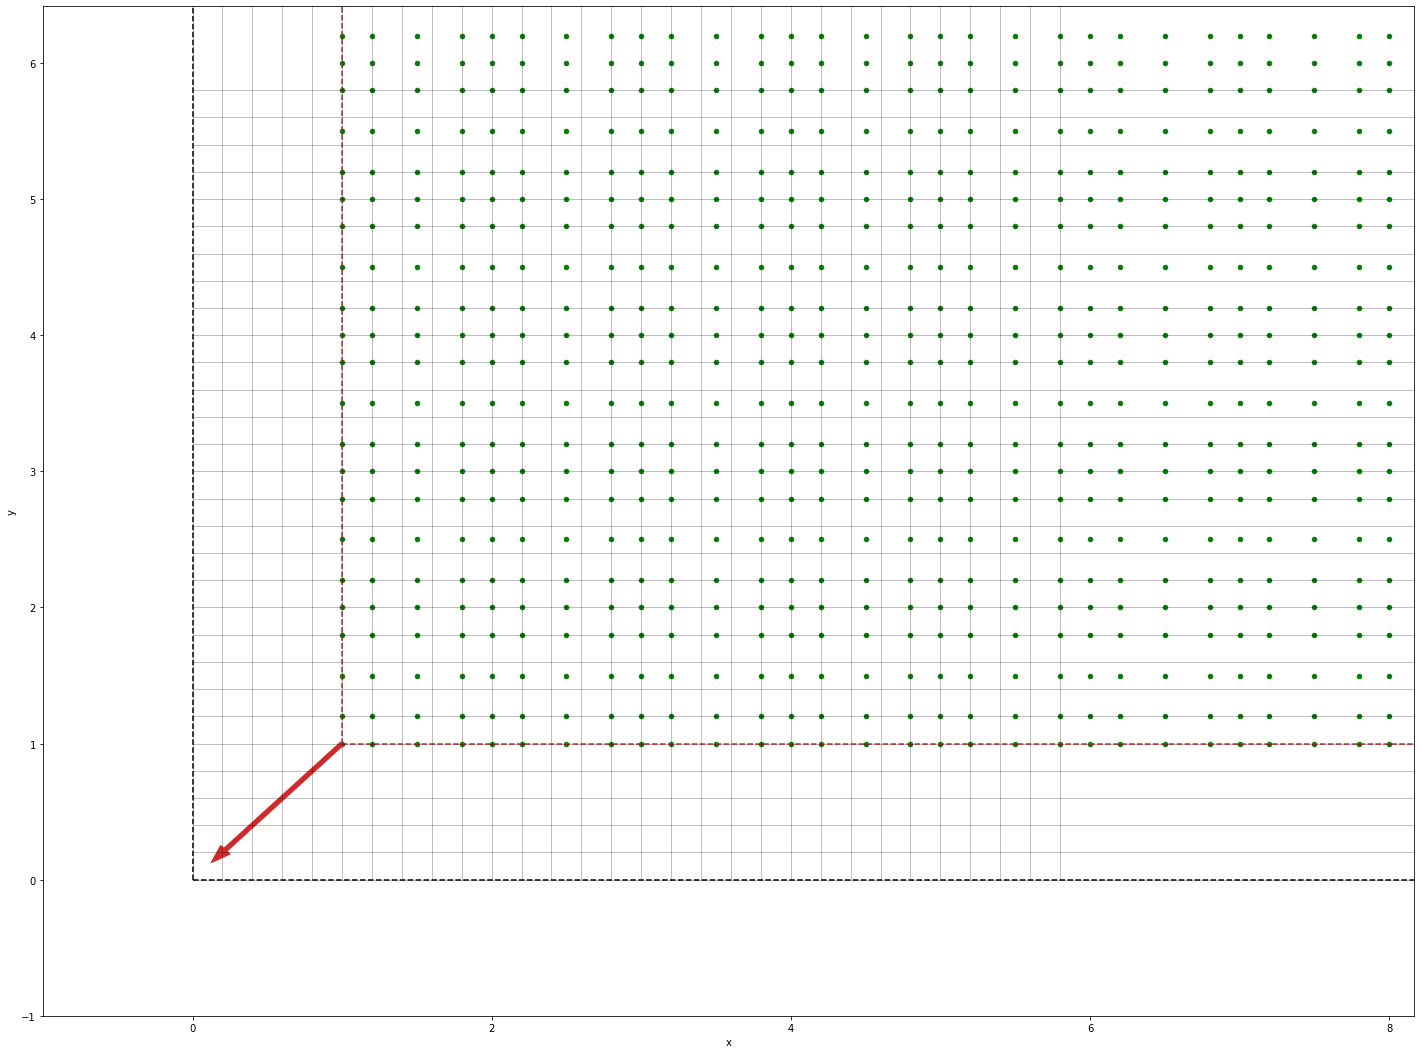

In [21]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df_trim_avg.x, df_trim_avg.y, s=20, c="g")

plt.arrow(x=X_Min+(X_step*dN), y=Y_Min+(Y_step*dN), 
          dx=-(X_step*(dN-0.5))+0.12, dy=-(Y_step*(dN-0.5))+0.12, 
          width=.03, color="tab:red") 

# Old Border
plt.plot([X_Min, X_Max],[Y_Max, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Min, X_Max],[Y_Min, Y_Min],'--', color='black', alpha=1)
plt.plot([X_Min, X_Min],[Y_Min, Y_Max],'--', color='black', alpha=1)
plt.plot([X_Max, X_Max],[Y_Min, Y_Max],'--', color='black', alpha=1)

# New Border
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Max-(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Min+(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Min+(X_step*dN), X_Min+(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)
plt.plot([X_Max-(X_step*dN), X_Max-(X_step*dN)],[Y_Min+(Y_step*dN), Y_Max-(Y_step*dN)],'--', color='tab:red', alpha=1)

for i in range(30):
    plt.plot([X_Min, X_Max],[Y_Min+(i*Y_step_trim), Y_Min+(i*Y_step_trim)],'-', linewidth=0.5, color='black', alpha=0.5)
    plt.plot([X_Min+(i*X_step_trim), X_Min+(i*X_step_trim)],[Y_Min, Y_Max],'-', linewidth=0.5, color='black', alpha=0.5)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-1,(X_Max/30)+1)
plt.ylim(-1,(Y_Max/30)+1)

plt.show()

We need to shift each data point such that they sit at the center of each element. We also would like for the bottom-left element to be located at (0,0). In other words, the bottom-left data point needs to be located at (0.5\*X_step, 0.5\*Y_step).

In [22]:
df_trim_avg_shift = df_trim_avg.copy()

df_trim_avg_shift["x"] -= ((dN-0.5)*X_step_trim)
df_trim_avg_shift["y"] -= ((dN-0.5)*Y_step_trim)

display(df_trim_avg_shift)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.561194,0.400784,2.988977,0.1,0.1,0.0,7,3,45
1,2.561194,0.400784,2.988977,0.1,0.3,0.0,7,3,45
2,2.561194,0.400784,2.988977,0.1,0.6,0.0,7,3,45
3,2.561194,0.400784,2.988977,0.1,0.9,0.0,7,3,45
4,2.561194,0.400784,2.988977,0.1,1.1,0.0,7,3,45
...,...,...,...,...,...,...,...,...,...
548474,1.227487,1.797343,5.415260,213.1,159.6,0.0,9,3,45
548475,1.227487,1.797343,5.415260,213.1,159.9,0.0,9,3,45
548476,1.227487,1.797343,5.415260,213.1,160.1,0.0,9,3,45
548477,1.227487,1.797343,5.415260,213.1,160.3,0.0,9,3,45


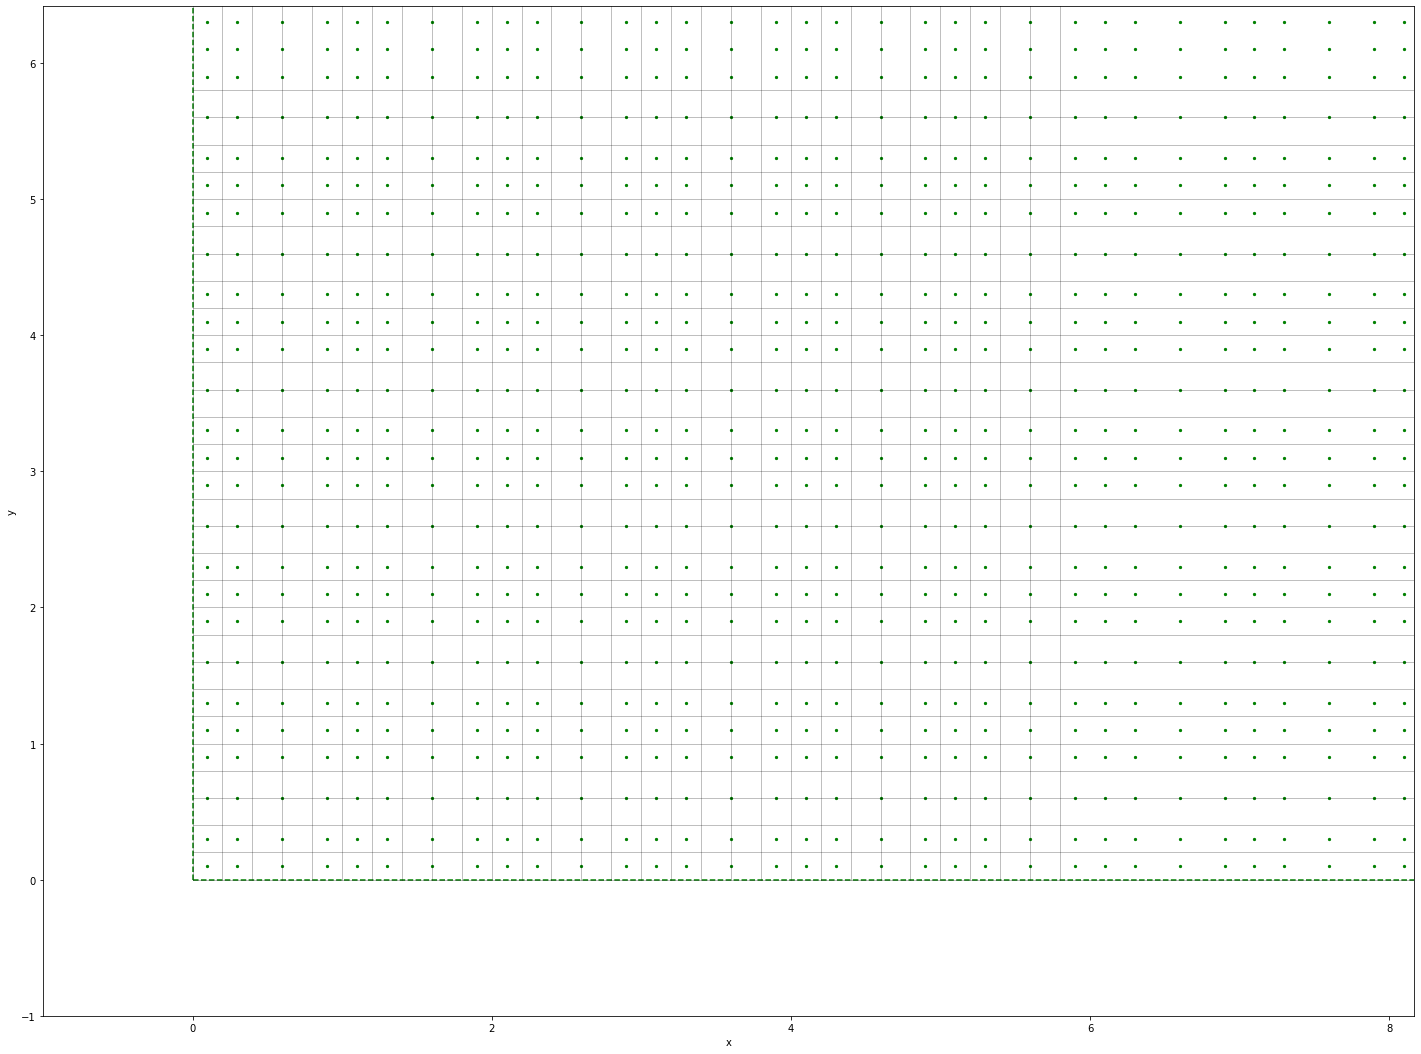

In [23]:
Plot_Scalling_Factor = 35
plt.rcParams["figure.figsize"] = (X_Dim/Plot_Scalling_Factor, Y_Dim/Plot_Scalling_Factor)

plt.scatter(df_trim_avg_shift.x, df_trim_avg_shift.y, s=5, c="g")

# Old Border
plt.plot([X_Min, X_Max],[Y_Max, Y_Max],'--', color='green', alpha=1)
plt.plot([X_Min, X_Max],[Y_Min, Y_Min],'--', color='green', alpha=1)
plt.plot([X_Min, X_Min],[Y_Min, Y_Max],'--', color='green', alpha=1)
plt.plot([X_Max, X_Max],[Y_Min, Y_Max],'--', color='green', alpha=1)

for i in range(30):
    plt.plot([X_Min, X_Max],[Y_Min+(i*Y_step_trim), Y_Min+(i*Y_step_trim)],'-', linewidth=0.5, color='black', alpha=0.5)
    plt.plot([X_Min+(i*X_step_trim), X_Min+(i*X_step_trim)],[Y_Min, Y_Max],'-', linewidth=0.5, color='black', alpha=0.5)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(-1,(X_Max/30)+1)
plt.ylim(-1,(Y_Max/30)+1)

plt.show()

In [24]:
X_step_trim_avg_shift = round(X_step_trim,3)
X_Max_trim_avg_shift = round(df_trim_avg_shift["x"].max()+(X_step_trim/2),3)
X_Min_trim_avg_shift = abs(round(df_trim_avg_shift["x"].min()-(X_step_trim/2),3))
X_Dim_trim_avg_shift = round((X_Max_trim - X_Min_trim) / X_step_trim,3)+1.0

Y_step_trim_avg_shift = round(Y_step_trim,3)
Y_Max_trim_avg_shift = round(df_trim_avg_shift["y"].max()+(Y_step_trim/2),3)
Y_Min_trim_avg_shift = abs(round(df_trim_avg_shift["y"].min()-(Y_step_trim/2),3))
Y_Dim_trim_avg_shift = round((Y_Max_trim_avg_shift - Y_Min_trim_avg_shift) / Y_step_trim,3)


print("X_Max_trim_avg_shift:\t" + str(X_Max_trim_avg_shift))
print("X_Min_trim_avg_shift:\t" + str(X_Min_trim_avg_shift))
print("X_step_trim_avg_shift:\t" + str(X_step_trim_avg_shift))
print("X_Dim_trim_avg_shift:\t" + str(X_Dim_trim_avg_shift))
print("\n")
print("Y_Max_trim_avg_shift:\t" + str(Y_Max_trim_avg_shift))
print("Y_Min_trim_avg_shift:\t" + str(Y_Min_trim_avg_shift))
print("Y_step_trim_avg_shift:\t" + str(Y_step_trim_avg_shift))
print("Y_Dim_trim_avg_shift:\t" + str(Y_Dim_trim_avg_shift))
print("\n")




X_Max_trim_avg_shift:	213.2
X_Min_trim_avg_shift:	0.0
X_step_trim_avg_shift:	0.2
X_Dim_trim_avg_shift:	1066.0


Y_Max_trim_avg_shift:	160.7
Y_Min_trim_avg_shift:	0.0
Y_step_trim_avg_shift:	0.2
Y_Dim_trim_avg_shift:	803.5




## Error 5: Mirror image across y axis

An SEM raster sets the origin at the top-left corner of the image window. By convention in the phase field method, we define the bottom-left corner as the origin. We need to mirror the data points across the y-axis, which can be done by flipping the sign of each y value, and adding the length of the y-dimension to the y value.

In [25]:
df_trim_avg_shift_mirror = df_trim_avg_shift.copy()

df_trim_avg_shift_mirror.y = -1.0*df_trim_avg_shift_mirror.y + Y_Max_trim_avg_shift

display(df_trim_avg_shift_mirror)

,phi1,Phi,phi2,x,y,z,grain,phase,symm
0,2.561194,0.400784,2.988977,0.1,160.6,0.0,7,3,45
1,2.561194,0.400784,2.988977,0.1,160.4,0.0,7,3,45
2,2.561194,0.400784,2.988977,0.1,160.1,0.0,7,3,45
3,2.561194,0.400784,2.988977,0.1,159.8,0.0,7,3,45
4,2.561194,0.400784,2.988977,0.1,159.6,0.0,7,3,45
...,...,...,...,...,...,...,...,...,...
548474,1.227487,1.797343,5.415260,213.1,1.1,0.0,9,3,45
548475,1.227487,1.797343,5.415260,213.1,0.8,0.0,9,3,45
548476,1.227487,1.797343,5.415260,213.1,0.6,0.0,9,3,45
548477,1.227487,1.797343,5.415260,213.1,0.4,0.0,9,3,45


# Writing to New Input File

In [26]:
NumGrains = df_trim_avg_shift_mirror.groupby("phase", as_index=False)["grain", "symm"].nunique()

BCCGrains = NumGrains.at[NumGrains.index[NumGrains["phase"]==2].tolist()[0], "grain"]
FCCGrains = NumGrains.at[NumGrains.index[NumGrains["phase"]==3].tolist()[0], "grain"]

display(NumGrains)

/var/folders/z_/zb7xrpz97lj_rnystyvxpfqh0000gn/T/ipykernel_44428/2392031305.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  NumGrains = df_trim_avg_shift_mirror.groupby("phase", as_index=False)["grain", "symm"].nunique()


,phase,grain,symm
0,2,3,1
1,3,6,1


In [27]:
writeLocation = "./Cleaned_AM_6_9T_M2_2_Run1.txt"

with open(writeLocation, 'w') as f:   
    f.write("""# Header:\tMarmot Input File
#
# Column 1:\tEuler angle "phi1" (in radians)
# Column 2:\tEuler angle "PHI" (in radians)
# Column 3:\tEuler angle "phi2" (in radians)
# Column 4:\tx-coordinate (in microns)
# Column 5:\ty-coordinate (in microns)
# Column 6:\tz-coordinate (in microns)
# Column 7:\tgrain number (integer)
# Column 8:\tphase number (integer)
# Column 9:\tsymmetry class (from TSL)
""")
    
with open(writeLocation, 'a') as f:   
    f.write("""#
# Phase 1: notIndexed (symmetry class = 0)
# Number of grains in Phase 1: 0
#
# Phase 2: Iron bcc (old) (symmetry class = 45)
# Number of grains in Phase 2: {}
#
# Phase 3: Iron fcc (symmetry class = 45)
# Number of grains in Phase 3: {}
""".format(BCCGrains, FCCGrains))
    
with open(writeLocation, 'a') as f:   
    f.write("""#
# X_Min:\t{}
# X_Max:\t{}
# X_step:\t{}
# X_Dim:\t{}
""".format(X_Min_trim_avg_shift, X_Max_trim_avg_shift, X_step_trim_avg_shift, X_Dim_trim_avg_shift))
    
with open(writeLocation, 'a') as f:   
    f.write("""#
# Y_Min:\t{}
# Y_Max:\t{}
# Y_step:\t{}
# Y_Dim:\t{}
""".format(Y_Min_trim_avg_shift, Y_Max_trim_avg_shift, Y_step_trim_avg_shift, Y_Dim_trim_avg_shift))
    
with open(writeLocation, 'a') as f:   
    f.write("""#
# Z_Min:\t0.0
# Z_Max:\t0.0
# Z_step:\t0.0
# Z_Dim:\t0.0
#
# Note:  This is a 2D dataset with z-coordinates set to zero!
#
""")
    
with open(writeLocation, 'a') as f:
    dfAsString = df_trim_avg_shift_mirror.to_string(header=False, index=False)
    f.write(dfAsString)
    
    

# Plotting the final structure

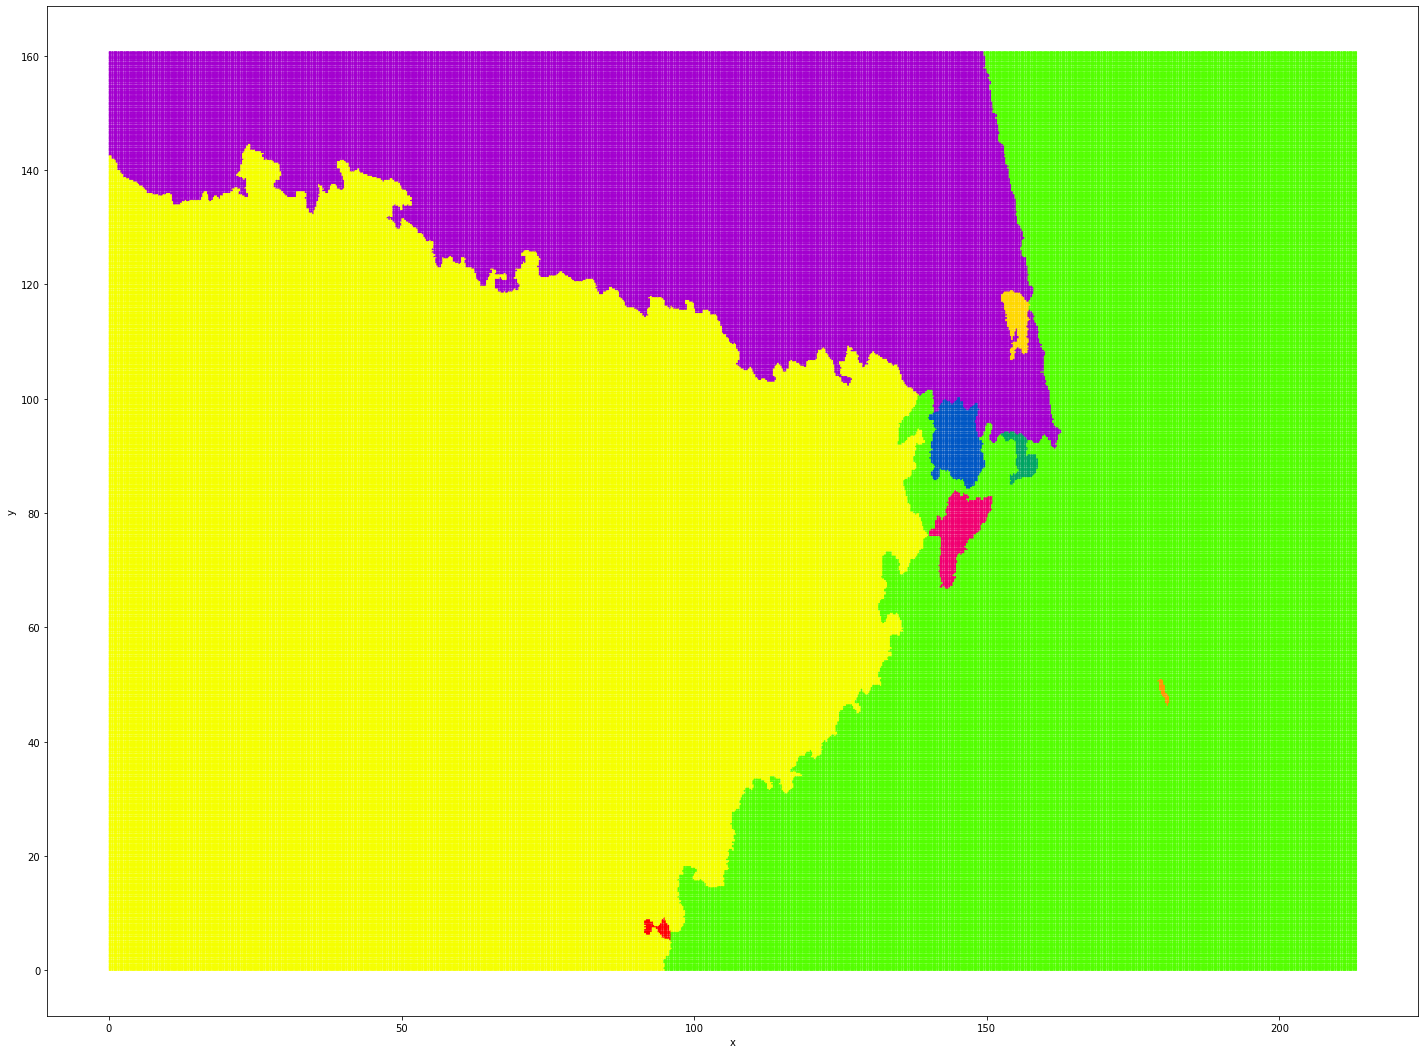

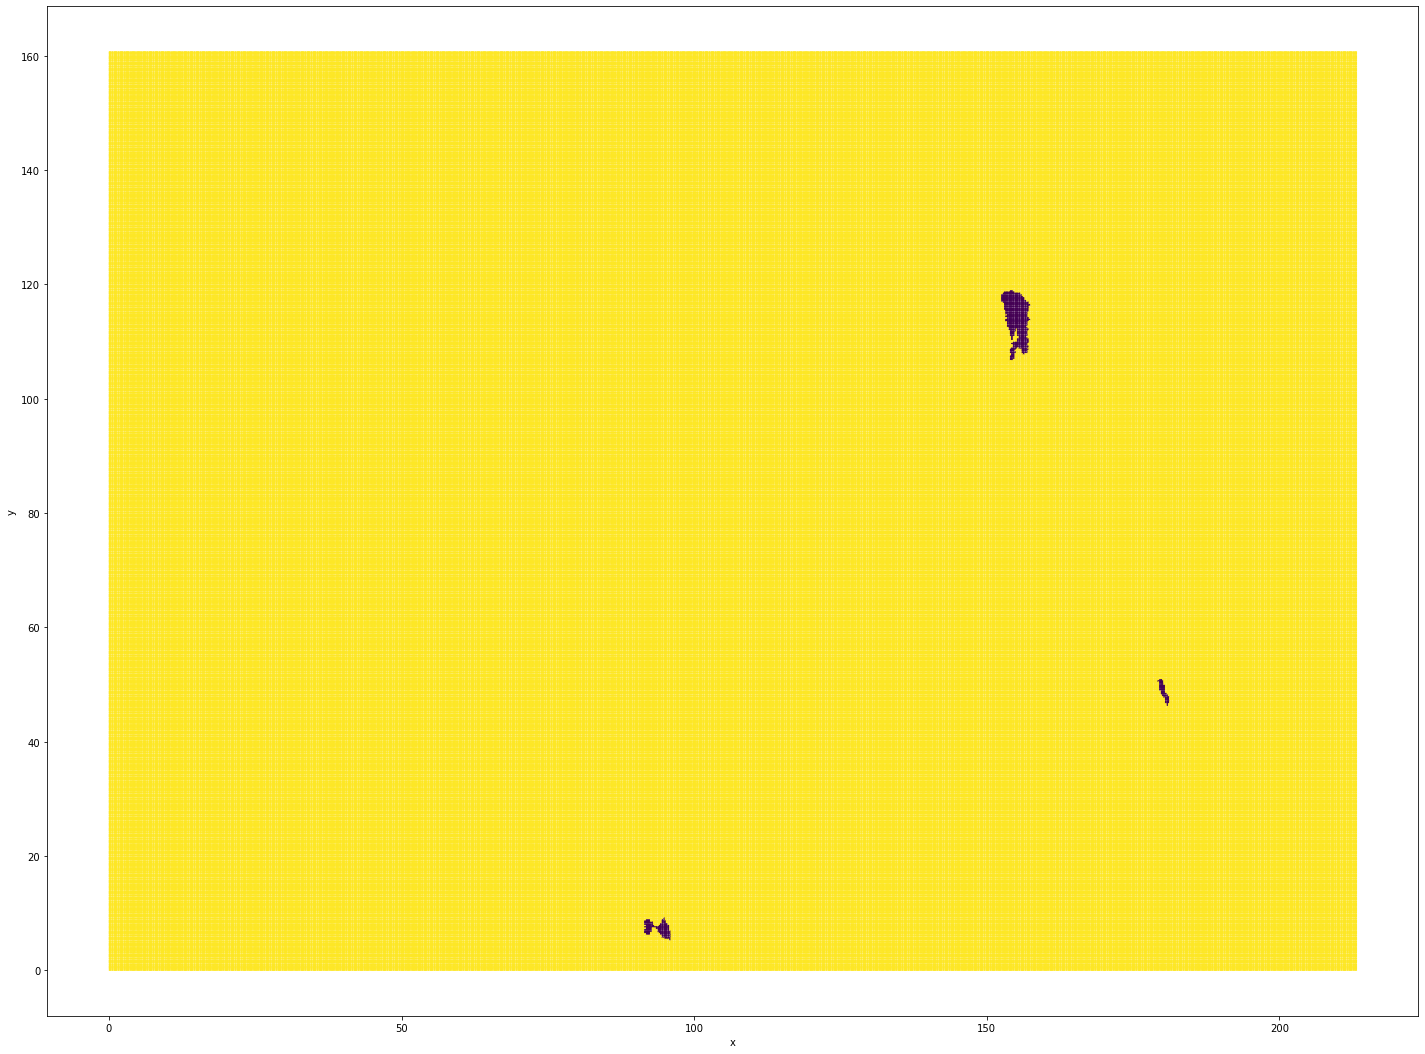

In [28]:
def scale_to_unity(s):
    return (s - s.min()) / (s.max() - s.min())

def series_to_colors(s, cmap):
    color_map = plt.get_cmap(cmap)
    return scale_to_unity(s).apply(color_map)

df_trim_avg_shift_mirror.plot.scatter('x', 'y', c=series_to_colors(df_trim_avg_shift_mirror.grain, 'prism'), s=1)
df_trim_avg_shift_mirror.plot.scatter('x', 'y', c=series_to_colors(df_trim_avg_shift_mirror.phase, 'viridis'), s=1);
